In [1]:
#!pip install numpy
#!pip install --user -U nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#!pip install unidecode
#!pip install matplotlib
#!pip install pyhive
#!pip install seaborn
#!pip install wordcloud
#!pip install boto3

In [2]:
import pandas as pd
import nltk
import time
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import RSLPStemmer
from unidecode import unidecode
from pyhive import hive
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from wordcloud import WordCloud, STOPWORDS 
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
# Libs aws
#import boto3
#from boto3.dynamodb.conditions import Key, Attr
#from botocore.exceptions import ClientError

warnings.filterwarnings("ignore")

In [3]:
#Carrega dados refined do Hive
#conn = hive.Connection(host=host,port= 10000)
#dataframe = pd.read_sql("SELECT wiki_id, title, wiki_timestamp, wiki_user, bot FROM defined.wikidata", conn)

In [4]:
#Carrega dados raw do csv
df_full = pd.read_csv("../../s3_data/raw/mergedfile_v3.csv", names=["schema", "wiki_id", "type", "namespace", "title", "comment", "timestamp", "user", "bot", "minor", "patrolled", "server_url", "server_name", "server_script_path", "wiki", "parsedcomment"])

df = df_full[["wiki_id", "title", "timestamp", "user","bot"]]
# Remove duplicados
df = df.drop_duplicates()
df.head()

,wiki_id,title,timestamp,user,bot
0,96930022,'Categoria:!Esboços maiores que 1000 bytes',1587209351,'170.79.220.123',False
1,96930023,'Categoria:!Esboços menores que 1001 bytes',1587209351,'170.79.220.123',False
2,96940639,'Categoria:!Páginas com ficheiros inexistentes',1587241013,'179.124.221.246',False
3,96940640,'Categoria:Nascidos em 2000',1587241013,'179.124.221.246',False
4,96940638,'Categoria:Nascidos em 2002',1587241013,'179.124.221.246',False


## Pré Processamento

In [5]:
#Remove linhas com dados nulos, transformando em minusculo e removendo aspas simples
df.dropna(inplace=True)
df["user"] = df["user"].replace({'\'': ''}, regex=True)
lw_text = df["title"].str.lower()
lw_text = lw_text.replace({'\'': ''}, regex=True)
df["user"] = df["user"].str.strip().replace({'^[0-9]*$': 'unknown'}, regex=True)

In [6]:
#Normalizando timestamp
s = "01/01/2020"
default_timestamp = int(datetime.datetime.strptime('01/01/2020', '%d/%m/%Y').strftime("%s"))
df["timestamp"] = df["timestamp"].str.strip().replace({'^((?![0-9]).)*$': default_timestamp}, regex=True)

In [7]:
#Substitui valores diferentes de booleano pela item de maior frequencia
#max_freq = df.bot.mode()[0]
#df["bot"] = df["bot"].str.strip().replace({'^((?!(False|True)).)*$': max_freq.strip()}, regex=True)

In [8]:
#Cria os tokens dos titulos
tokens =  lw_text.apply(word_tokenize)

In [9]:
#Normalizando com unicode
tokens_uni = tokens.apply(lambda x: [unidecode(z) for z in x ])

In [10]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.extend(['categoria','artigos', 'predefinicao','ficheiro','sobre','predefinicoes','redirecionamentos','esbocos','ligados','elemento','inexistentes','ficheiros','usuario','wikidata','paginas','wikipedia','discussao','lista'])
stopwords = set(stopwords + list(punctuation))
title_cleaned = tokens_uni.apply(lambda line:  [w for w in line if not w in stopwords])

In [11]:
#Cria coluna com os titulos tratados
df["title_cleaned"] = title_cleaned.apply(lambda line: " ".join(line))
df.replace("", np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,wiki_id,title,timestamp,user,bot,title_cleaned
131072,97475656,Faxinildo,1589310939,Fã dos sites,False,faxinildo
131073,97475664,Rumours,1589310945,Leandro Drudo,False,rumours
131074,97475665,Petrix Barbosa,1589310945,79a,False,petrix barbosa
131075,97475666,Usuário(a) Discussão:Alexromeu,1589310955,79a,False,alexromeu
131076,97475667,Usuário(a):The WWE man,1589310962,The WWE man,False,the wwe man


In [12]:
#Cria coluna com os titulos com steamming
def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

stemmed_list = title_cleaned.apply(lambda line: Stemming(line))
df["title_stemmed"] = stemmed_list.apply(lambda line: " ".join(line))
df.head()

,wiki_id,title,timestamp,user,bot,title_cleaned,title_stemmed
131072,97475656,Faxinildo,1589310939,Fã dos sites,False,faxinildo,faxinild
131073,97475664,Rumours,1589310945,Leandro Drudo,False,rumours,rumour
131074,97475665,Petrix Barbosa,1589310945,79a,False,petrix barbosa,petrix barb
131075,97475666,Usuário(a) Discussão:Alexromeu,1589310955,79a,False,alexromeu,alexrom
131076,97475667,Usuário(a):The WWE man,1589310962,The WWE man,False,the wwe man,the wwe man


## Análises

In [20]:
# Separa dataframe entre alterados e não alterados por bot
title_bot_true_full = df[df.bot==True]
title_bot_false_full = df[df.bot==False]

## Gráfico da quantidade de registros

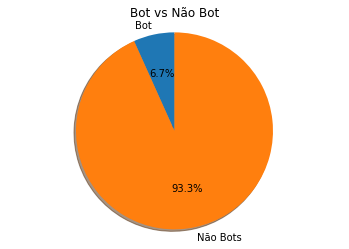

In [21]:
# Vec. transform com bots = true
str_list = title_bot_true_full["title_stemmed"].values
vec = TfidfVectorizer()
vec.fit(str_list)
features_bot_true = vec.transform(str_list)

# Vec. transform com bots = false
str_list = title_bot_false_full["title_stemmed"].values
vec.fit(str_list)
features_bot_false = vec.transform(str_list)

labels = 'Bot','Não Bots'
data = [features_bot_true.size, features_bot_false.size]

fig1, ax1 = plt.subplots()

ax1.pie(data, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

ax1.axis('equal')
ax1.set_title("Bot vs Não Bot")
plt.show()

## Dendograma top 100

In [28]:
top_N = 100
words = df["title_cleaned"].str.cat(sep=' ').split()
rslt = pd.DataFrame(Counter(words).most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

              Frequency
Word                   
pandemia            763
covid-19            693
brasil              616
futebol             609
eliminacao          582
...                 ...
populacional         89
iorque               86
nacional             85
distrito             84
big                  84

[100 rows x 1 columns]


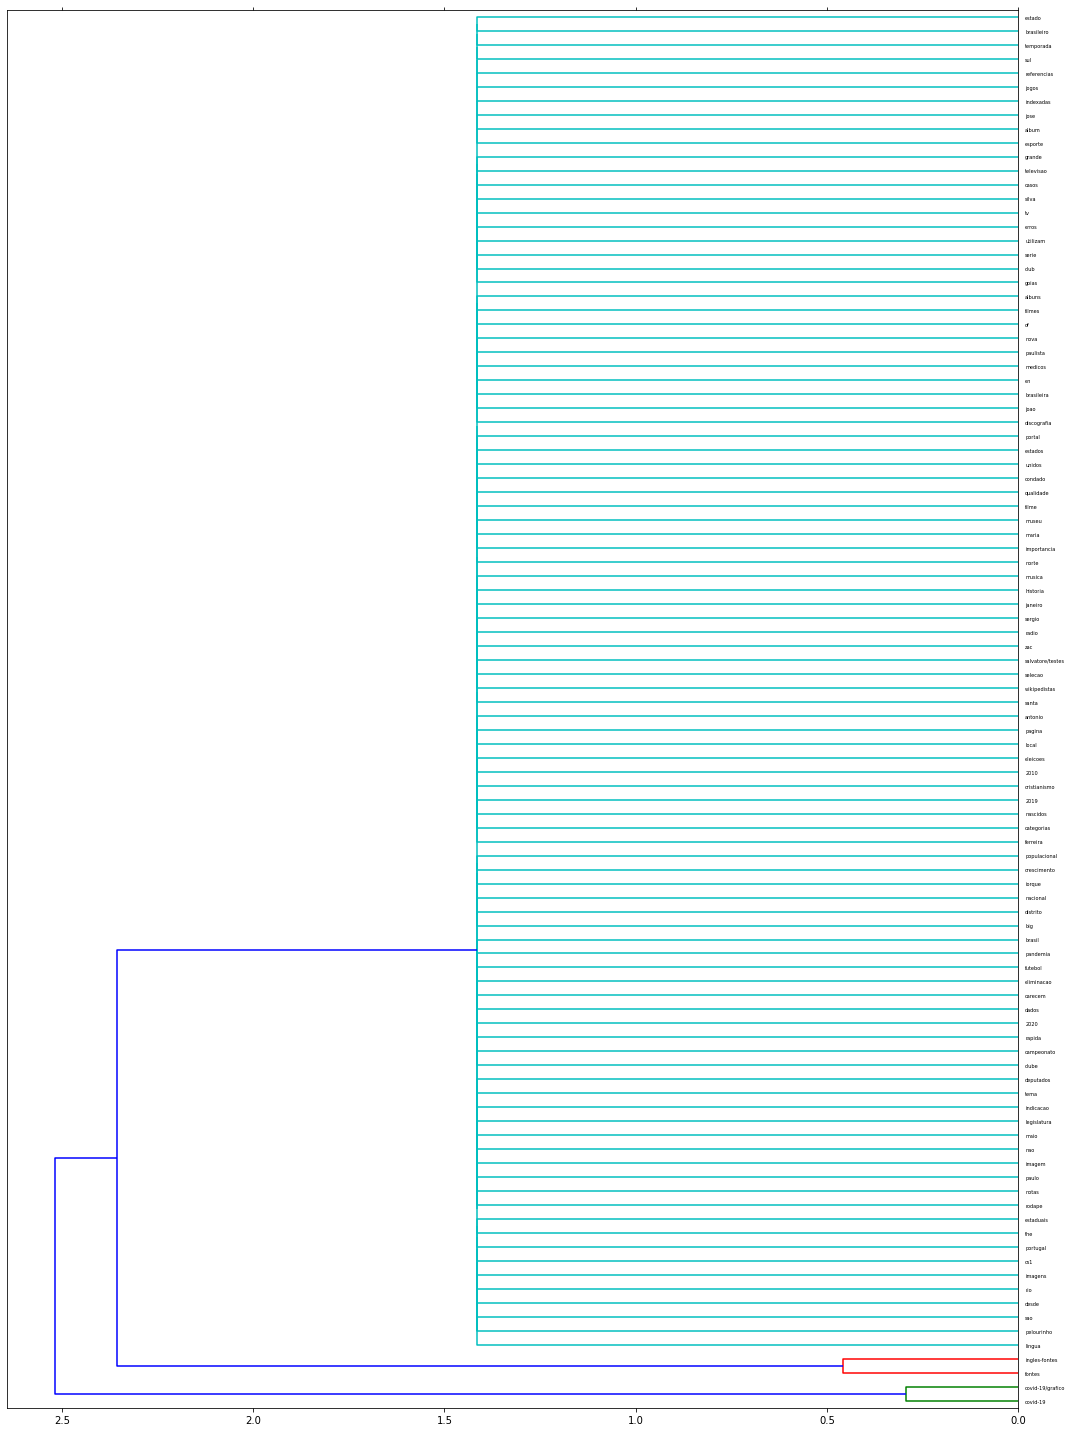

In [29]:
str_list = rslt.index.values
vec = TfidfVectorizer()
vec.fit(str_list)
matrix_transf = vec.transform(str_list)

from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - cosine_similarity(matrix_transf)
linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 20)) 
ax = dendrogram(linkage_matrix, orientation="left", labels=str_list);

plt.tick_params(\
    axis= 'x',          
    which='both',      
    bottom='off',     
    top='off',         
    labelbottom='off')

plt.tight_layout() 

plt.savefig('ward_clusters.png', dpi=200)

## Análise de todas as palavras

In [30]:
## Word Cloud

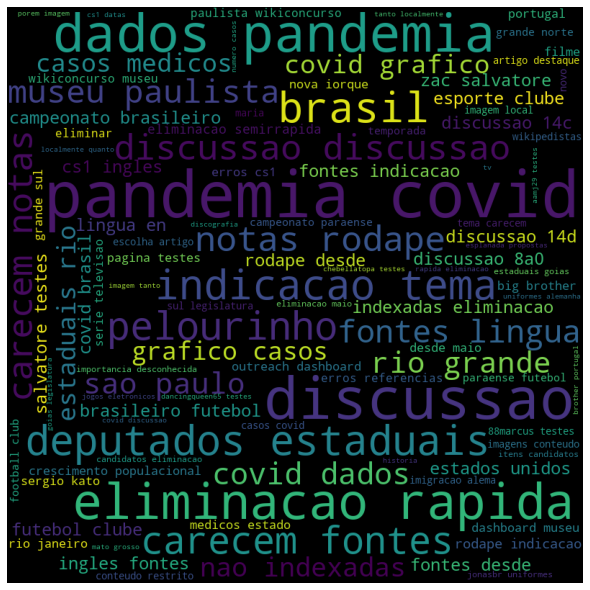

In [31]:
lst_words = ''
lst_words += " ".join(words)+ " "

wordcloud = WordCloud(width = 800, height = 800, 
                min_font_size = 10).generate(lst_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Top 10 títulos alterados por bot

            Frequency
Word                 
covid-19          370
pandemia          361
dados             359
casos              60
numero             58
pagina             48
imagem             42
testes/1           37
imagens            37
categorias         35


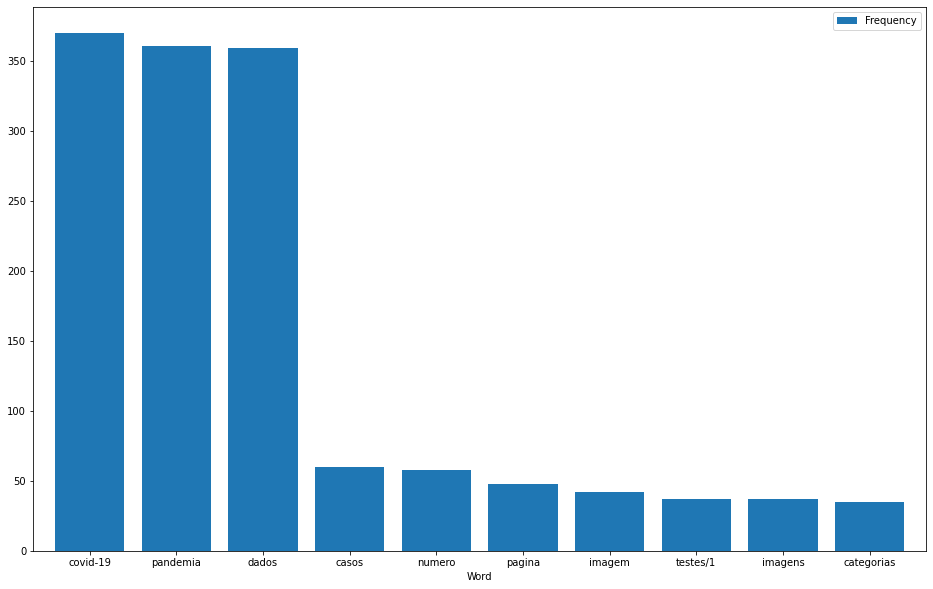

In [32]:
#bot = true
top_N = 10
words = title_bot_true_full["title_cleaned"].str.cat(sep=' ').split()
rslt = pd.DataFrame(Counter(words).most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

## Top 10 títulos não alterados por bots

            Frequency
Word                 
brasil            599
eliminacao        582
futebol           578
carecem           532
2020              460
rapida            437
pandemia          402
campeonato        338
clube             335
covid-19          323


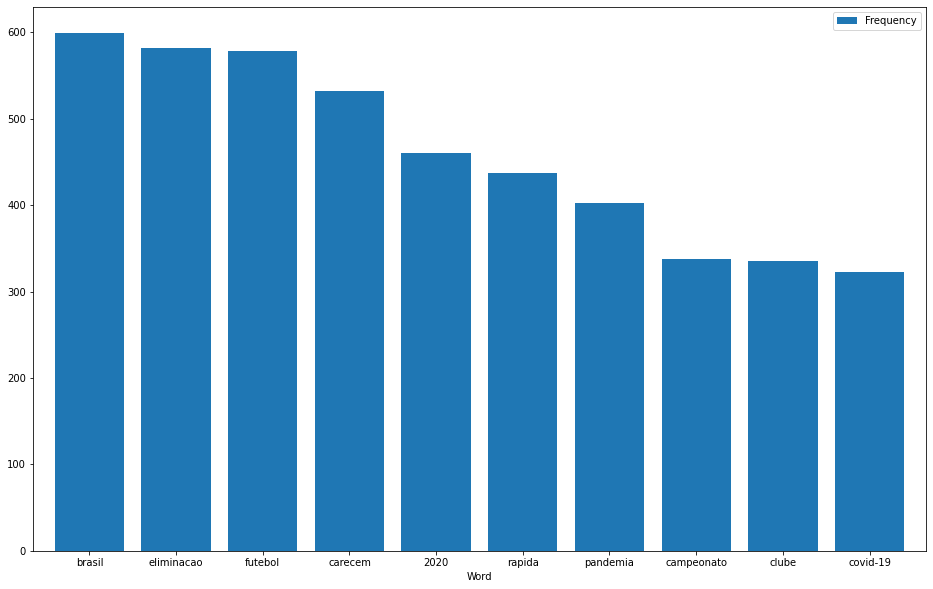

In [33]:
#bot = false
top_N = 10
words = title_bot_false_full["title_cleaned"].str.cat(sep=' ').split()
rslt = pd.DataFrame(Counter(words).most_common(top_N), columns=['Word', 'Frequency']).set_index('Word')
print(rslt)
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

## K-Means bot = false

In [34]:
# Amostra das bases
title_bot_false = title_bot_false_full.sample(frac=0.10)
title_bot_true = title_bot_true_full.sample(frac=0.10)

In [35]:
K = range(2,30)
for n_clusters in K:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(features_bot_false)
    centers = clusterer.cluster_centers_

    score = silhouette_score(features_bot_false, preds)
    print("Para n_clusters = {}, silhouette score é {})".format(n_clusters, score))

Para n_clusters = 2, silhouette score é 0.004572732655051248)
Para n_clusters = 3, silhouette score é 0.017574839370025554)
Para n_clusters = 4, silhouette score é 0.018932060220554804)
Para n_clusters = 5, silhouette score é 0.019904880305883194)
Para n_clusters = 6, silhouette score é 0.021291579046003577)
Para n_clusters = 7, silhouette score é 0.02526549559989224)
Para n_clusters = 8, silhouette score é 0.027217798945164223)
Para n_clusters = 9, silhouette score é 0.03315353032403929)
Para n_clusters = 10, silhouette score é 0.032127641041954015)
Para n_clusters = 11, silhouette score é 0.03261514537085327)
Para n_clusters = 12, silhouette score é 0.03353695577385147)
Para n_clusters = 13, silhouette score é 0.033732950532721066)
Para n_clusters = 14, silhouette score é 0.03436986580630375)
Para n_clusters = 15, silhouette score é 0.03603904732260383)
Para n_clusters = 16, silhouette score é 0.04538505040075775)
Para n_clusters = 17, silhouette score é 0.04084684037381227)
Para n_c

In [36]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_bot_false)
    Sum_of_squared_distances.append(km.inertia_)


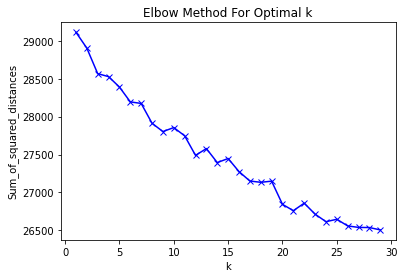

In [37]:
#Best result cluster = 150
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

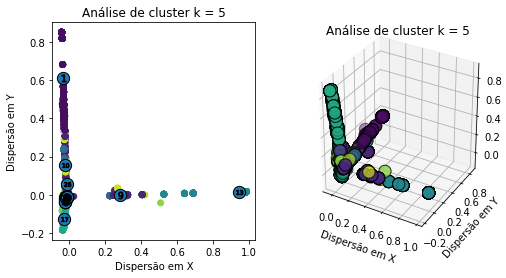

In [38]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)

#Visualização gráfica 2D     # Converte as features para 2D     
pca = PCA(n_components=2, random_state= 0)
reduced_features = pca.fit_transform(features_bot_false.toarray())

# Converte os centros dos clusters para 2D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Plota gráfico 2D     
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(features_bot_false))
ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='o', s=150, edgecolor='k')

#Plota números nos clusters     
for i, c in enumerate(reduced_cluster_centers):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

cluster=5
#Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')



#Visualização gráfica 3D 

ax = fig.add_subplot(1, 2, 2,projection="3d")

# ax = plt.axes(projection="3d") 
# Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')

#converte dados para 3D     
pca = PCA(n_components=3, random_state=0)
reduced_features = pca.fit_transform(features_bot_false.toarray())

#Plota dados em 3D     
ax.scatter3D(reduced_features[:,0], reduced_features[:,1], reduced_features[:,2], marker='o', s=150, edgecolor='k', c=km.predict(features_bot_false))

# Converte os centros dos clusters para 3D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Salva arquivo de imagem 3D     
plt.savefig("../imagens_cluster_kmens/grafico_cluster_k=%d" % cluster)
plt.show()

## K-means bot = True

In [39]:
K = range(2,30)
for n_clusters in K:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(features_bot_true)
    centers = clusterer.cluster_centers_

    score = silhouette_score(features_bot_true, preds)
    print("Para n_clusters = {}, silhouette score é {})".format(n_clusters, score))

Para n_clusters = 2, silhouette score é 0.17815216287650423)
Para n_clusters = 3, silhouette score é 0.2003784573943305)
Para n_clusters = 4, silhouette score é 0.2098773664412403)
Para n_clusters = 5, silhouette score é 0.20806431972522532)
Para n_clusters = 6, silhouette score é 0.22140765287732425)
Para n_clusters = 7, silhouette score é 0.22135244387045355)
Para n_clusters = 8, silhouette score é 0.24184210035023654)
Para n_clusters = 9, silhouette score é 0.24393808316468427)
Para n_clusters = 10, silhouette score é 0.25975070037460124)
Para n_clusters = 11, silhouette score é 0.2599909373795272)
Para n_clusters = 12, silhouette score é 0.26377373761013784)
Para n_clusters = 13, silhouette score é 0.26494158841940435)
Para n_clusters = 14, silhouette score é 0.2720718795132279)
Para n_clusters = 15, silhouette score é 0.27280564251635925)
Para n_clusters = 16, silhouette score é 0.28239316702511597)
Para n_clusters = 17, silhouette score é 0.2725392634342573)
Para n_clusters = 18,

In [42]:
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_bot_true)
    Sum_of_squared_distances.append(km.inertia_)

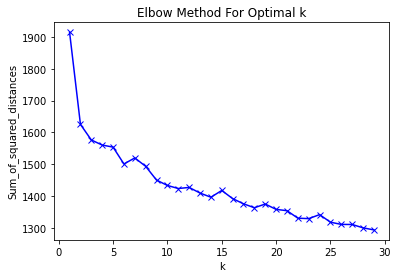

In [43]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

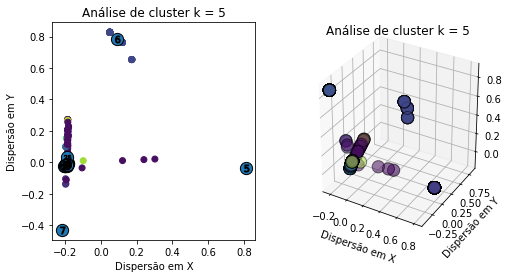

In [44]:
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)

#Visualização gráfica 2D     # Converte as features para 2D     
pca = PCA(n_components=2, random_state= 0)
reduced_features = pca.fit_transform(features_bot_true.toarray())

#Distancias calculadas com o fit_transform
reduced_features

# Converte os centros dos clusters para 2D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Plota gráfico 2D     
ax.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(features_bot_true))
ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='o', s=150, edgecolor='k')

#Plota números nos clusters     
for i, c in enumerate(reduced_cluster_centers):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

cluster=5
#Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')

#Visualização gráfica 3D 

ax = fig.add_subplot(1, 2, 2,projection="3d")

# ax = plt.axes(projection="3d") 
# Adiciona informações no gráfico     
plt.title("Análise de cluster k = %d" % cluster)
plt.xlabel('Dispersão em X')
plt.ylabel('Dispersão em Y')

#converte dados para 3D     
pca = PCA(n_components=3, random_state=0)
reduced_features = pca.fit_transform(features_bot_true.toarray())

#Plota dados em 3D     
ax.scatter3D(reduced_features[:,0], reduced_features[:,1], reduced_features[:,2], marker='o', s=150, edgecolor='k', c=km.predict(features_bot_true))

# Converte os centros dos clusters para 3D     
reduced_cluster_centers = pca.transform(km.cluster_centers_)

#Salva arquivo de imagem 3D     
plt.savefig("../imagens_cluster_kmens/grafico_cluster_k=%d" % cluster)
plt.show()

## DBScan

### bot = true

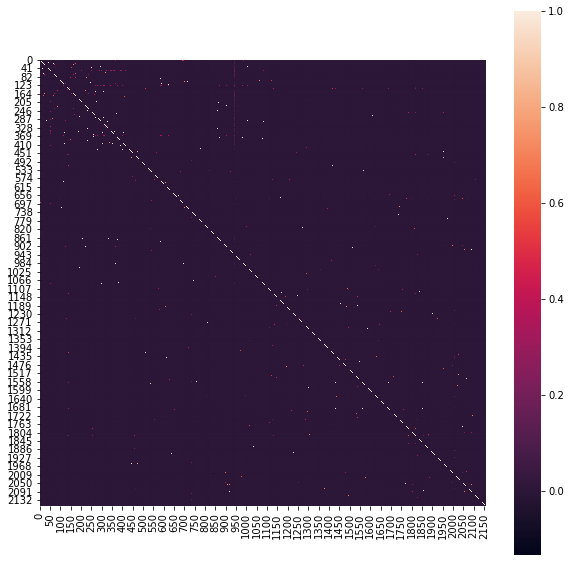

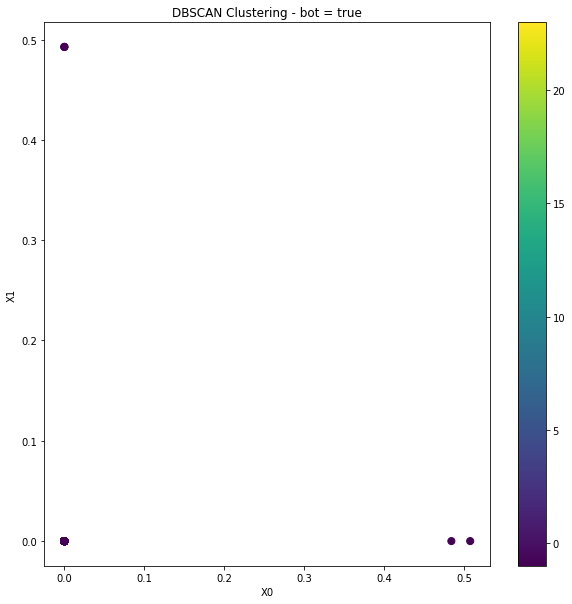

In [45]:
X = features_bot_true.toarray(); 
data = pd.DataFrame(X)
cor = data.corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(cor, square = True); plt.show()

# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Conduct DBSCAN Clustering
clt = DBSCAN()

# Train model
model = clt.fit(X_std)

# Predict clusters
clusters = pd.DataFrame(model.fit_predict(X_std))
data['Cluster'] = clusters

# Visualise cluster membership
fig = plt.figure(figsize=(10,10)); 
ax = fig.add_subplot(111)
scatter = ax.scatter(data[0],data[1], c=data['Cluster'],s=50)
ax.set_title('DBSCAN Clustering - bot = true')
ax.set_xlabel('X0'); 
ax.set_ylabel('X1')
plt.colorbar(scatter); 
plt.show()

### bot = False

In [ ]:
X = features_bot_false.toarray(); 
data = pd.DataFrame(X)
cor = data.corr()

fig = plt.figure(figsize=(10,10))
sns.heatmap(cor, square = True); plt.show()

# Standarize features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Conduct DBSCAN Clustering
clt = DBSCAN()

# Train model
model = clt.fit(X_std)

# Predict clusters
clusters = pd.DataFrame(model.fit_predict(X_std))
data['Cluster'] = clusters

# Visualise cluster membership
fig = plt.figure(figsize=(10,10)); 
ax = fig.add_subplot(111)
scatter = ax.scatter(data[0],data[1], c=data['Cluster'],s=50)
ax.set_title('DBSCAN Clustering - bot = false')
ax.set_xlabel('X0'); 
ax.set_ylabel('X1')
plt.colorbar(scatter); 
plt.show()